In [21]:
# Task: Puma Data Challenge
# Author: Umut Bayrak
# Version: Python 3
# Last Update: 29.07.2018 19:12

In [22]:
## Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split   # To split the dataset into train and test
from sklearn.ensemble import RandomForestClassifier  # To apply Random Forest
from sklearn.linear_model import LogisticRegression  # To apply Logistic Regression
from sklearn.metrics import roc_auc_score  # To evaluate the models


# Read in data

clothes = pd.read_csv("C:/Users/Umut/Desktop/PumaDataChallenge/clothes_puma.csv", 
                      sep = ",", header = 0)
evolutions = pd.read_csv("C:/Users/Umut/Desktop/PumaDataChallenge/evolutions_puma.csv", 
                         sep = ";", usecols = [0, 1, 2, 3, 4, 5])
                        

In [23]:
## Checking the data
evolutions.info()
evolutions.isnull().values.any()  # Checkign the missing data
evolutions['timestamp'] = pd.to_datetime(evolutions['timestamp'])  # Transforming timestamp to a date-time object

## There are different forms of colors e.g. "Black" and "BLACK". In order to remove these differences I capitalized them.  
evolutions.color = evolutions.color.str.upper()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49318 entries, 0 to 49317
Data columns (total 6 columns):
product_id    49318 non-null object
color         49318 non-null object
timestamp     49318 non-null object
type          49318 non-null object
value         49318 non-null object
size_name     49318 non-null object
dtypes: object(6)
memory usage: 2.3+ MB


In [24]:
# To get the duration of sales first and last days are extracted
time_range = evolutions.groupby("product_id")["timestamp"].agg(["first","last"]) 

# Duration is calculated here
time_range["diff"] = time_range["last"] - time_range["first"]

# product_id is added as a column (it was an index before caused by .agg() method)
time_range.columns = list(map(''.join, time_range.columns.values))
time_range["product_id"] = time_range.index.values

In [25]:
## PART I: BESTSELLER
# Here I try to define bestseller on my own. Because I didn't realize that there is a "best sellers" tag 
# in the category label in the beginning. I wanted to keep these too.

#I define best sellers in three different ways:

# First: The most sold products
# Second: The fastest sold products
# Third: The highest revenue brought to the company

In [26]:
## FIRST: The most sold products
# The sum of the stock_decrease values for each products. I will list the top 7 products (10% of the total product groups)

sold = evolutions[evolutions.type == "stock_decrease"]
sold.loc[:,"value"] = sold.loc[:,"value"].apply(pd.to_numeric, errors='coerce') # converting to numeric

most_sold = sold.groupby("product_id", as_index = False)["value"].sum() # taking the sum of the stock_decrease per product_id
most_sold_order = most_sold.sort_values(by="value", ascending = False) # sorting the values according to the sum

most_sold_order.head(7)

C:\Users\Umut\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,product_id,value
27,http://eu.puma.com/it/en/pd/elsu-v2-canvas-tra...,917
58,http://eu.puma.com/it/en/pd/suede-classic%2B-t...,790
16,http://eu.puma.com/it/en/pd/basket-platform-re...,556
28,http://eu.puma.com/it/en/pd/epic-flip-v2-sanda...,371
9,http://eu.puma.com/it/en/pd/archive-logo-mens-...,237
21,http://eu.puma.com/it/en/pd/bvb-mens-fan-t-shi...,229
40,http://eu.puma.com/it/en/pd/mens-v-neck-t-shir...,191


In [117]:
## This is for presentation

names_sold = pd.merge(most_sold_order.head(7), clothes[["product_id", "main_title"]], how = "left", left_on = "product_id", right_on = "product_id")

names_sold.main_title = names_sold.main_title.str.replace("\n", "")
names_sold[["main_title", "value"]].head(7)


Index(['product_id', 'category', 'sub_category', 'main_title', 'colors'], dtype='object')

In [132]:
## SECOND: The fastest sold products

merged_frame = most_sold_order.merge(time_range, left_on = "product_id", right_on = "product_id") # merging with indexes
merged_frame["speed"] = merged_frame["value"] / merged_frame["diff"].dt.days # calculating the consumption speed
merged_speed = merged_frame.sort_values(by = "speed", ascending = False) # sorting by the speed
merged_speed.iloc[1:7,][["product_id", "speed"]]

,product_id,speed
30,http://eu.puma.com/it/en/pd/burst-mesh-womens-...,64.000000
0,http://eu.puma.com/it/en/pd/elsu-v2-canvas-tra...,19.510638
1,http://eu.puma.com/it/en/pd/suede-classic%2B-t...,16.808511
2,http://eu.puma.com/it/en/pd/basket-platform-re...,11.829787
3,http://eu.puma.com/it/en/pd/epic-flip-v2-sanda...,7.893617
5,http://eu.puma.com/it/en/pd/bvb-mens-fan-t-shi...,6.939394


In [138]:
## This is for presentation
names_speed = merged_speed.iloc[1:8,][["speed", "product_id"]]
names_speed_merge = pd.merge(names_speed, clothes[["product_id", "main_title"]], how = "left", left_on = "product_id", right_on = "product_id")
names_speed_merge.main_title = names_speed_merge.main_title.str.replace("\n", "")
names_speed_merge[["main_title", "speed"]]

In [28]:
## THIRD: The highest revenue bringing products
price = evolutions[evolutions.type == "price"] # creating the data table with price
price = price[price.value != "None"] # Excluding two observations containing "None" information 
stock = evolutions[evolutions.type == "stock_decrease"] # creating the data table with stock_decrease

# Merging down two frames
price_stock = pd.merge(price, stock,  how='inner', left_on=['product_id','timestamp'], right_on = ['product_id','timestamp'])

# Calculation of the daily revenue of each product
price_stock["revenue"] = price_stock.value_x.astype(float) * price_stock.value_y.astype(float)

# Voila, the result
merged_revenue = price_stock.groupby("product_id", as_index = False)["revenue"].sum().sort_values(by="revenue",ascending = False)
merged_revenue.head(7)

,product_id,revenue
58,http://eu.puma.com/it/en/pd/suede-classic%2B-t...,379200.0
27,http://eu.puma.com/it/en/pd/elsu-v2-canvas-tra...,192570.0
16,http://eu.puma.com/it/en/pd/basket-platform-re...,166800.0
35,http://eu.puma.com/it/en/pd/ignite-limitless-m...,31240.0
28,http://eu.puma.com/it/en/pd/epic-flip-v2-sanda...,26712.0
5,http://eu.puma.com/it/en/pd/active-training-wo...,26100.0
55,http://eu.puma.com/it/en/pd/style-mens-full-zi...,14616.0


In [144]:
## This is for presentation

rev = merged_revenue.iloc[0:7,]
revenue = pd.merge(rev, clothes[["main_title", "product_id"]], how="left", left_on="product_id", right_on="product_id")
revenue.main_title = revenue.main_title.str.replace("\n", "")
revenue[["main_title", "revenue"]]

,main_title,revenue
0,Suede Classic+ Trainers,379200.0
1,Elsu v2 Canvas Trainers,192570.0
2,Basket Platform Reset Women's Trainers,166800.0
3,IGNITE Limitless Men's Trainers,31240.0
4,Epic Flip v2 Sandals,26712.0
5,Active Training Women's All Eyes On Me 3/4 Tights,26100.0
6,Style Men's Full Zip Fleece Hoodie,14616.0


In [29]:
# PART II: PREDICTION

In [30]:
## Basetable creation from evolutions dataset. 
## From "type" column stock_decrease, price, and stock_size values are extracted. 
# (different colors of products considered as one product)

# stock_decrease data is grouped by product_id and timestamp and sum of the stock decrease is found here for daily sales
# each product. 

# from there: the mean, standard deviation of the sales, the days without sales (0_sales_days_count), 
# the days in which at least a product was sold (1_sales_day_count) 
# how long is the last sales date from the last date of the data (last_date)
# how long is the first sales data till the last date

stockdecrease_all = evolutions[evolutions.type == "stock_decrease"][["product_id", "timestamp", "value"]]
stockdecrease_all["value"]=stockdecrease_all["value"].astype(str).astype(int)
stockdecrease_all= stockdecrease_all.groupby(["product_id","timestamp"], as_index=False).sum()

stockdecrease = stockdecrease_all.groupby("product_id", as_index=False).sum().rename(columns={'value':'sales_sum'})
stockdecrease["sales_mean"] = stockdecrease_all.groupby("product_id", as_index=False).mean()["value"]
stockdecrease["sales_std"] = stockdecrease_all.groupby("product_id", as_index=False).agg(np.std, ddof=1)["value"]
stockdecrease["0_sales_days_count"] = stockdecrease_all[stockdecrease_all.value==0].groupby("product_id", as_index=False).count()["value"]
stockdecrease["1_sales_days_count"] = stockdecrease_all[stockdecrease_all.value!=0].groupby("product_id", as_index=False).count()["value"]
stockdecrease["max_sales"] = stockdecrease_all[stockdecrease_all.value!=0].groupby("product_id", as_index=False).max()["value"]
t = stockdecrease_all[stockdecrease_all.value!=0].groupby("product_id", as_index=False)["timestamp"].max()["timestamp"].max()
stockdecrease["last_date"] = (t-stockdecrease_all[stockdecrease_all.value!=0].groupby("product_id", as_index=False)["timestamp"].max()["timestamp"]).dt.days
stockdecrease["first_date"] = (t-stockdecrease_all[stockdecrease_all.value!=0].groupby("product_id", as_index=False)["timestamp"].min()["timestamp"]).dt.days

# stock_size is extracted here
stocksize_all = evolutions[evolutions.type == "stock_size"][["product_id", "timestamp", "value"]]
stocksize_all["value"]=stocksize_all["value"].astype(str).astype(int)
stocksize_all= stocksize_all.groupby(["product_id","timestamp"], as_index=False).sum()

# the maximum stock per product is calculated here
stockdecrease["max_stock"] = stocksize_all.groupby("product_id", as_index=False).max()["value"]


stockdecrease.head()

# price is extracted here

evo_reloaded = evolutions[evolutions.type == "price"][["product_id", "timestamp", "value"]]
evo_reloaded = evo_reloaded[evo_reloaded.value != "None"]
evo_reloaded.value = evo_reloaded.value.astype(float)

## mean and std price per product is calculated here and the price range in price_range
evolutions_new = evo_reloaded.groupby(["product_id", "timestamp"], as_index=False)["value"].mean()

price = evolutions_new.groupby("product_id", as_index=False)["value"].mean()
price.columns.values[1] = "price_mean"
price["price_std"] = evolutions_new.groupby("product_id", as_index=False)["value"].agg(np.std, ddof=1)["value"]
price["price_range"] = evolutions_new.groupby("product_id", as_index=False)["value"].agg(lambda x: max(x) - min(x))["value"]

price.head()

## Merging two datasets

price_stock = pd.merge(stockdecrease, price, how="inner", left_on = "product_id", right_on = "product_id")

In [31]:
## Category exraction from clothes dataset. 
# There are multiple categories for each product stored in a string. I split them and made separate variables with 0 and 1.
# If the product belong to that category it's 1, else 0

cleaned_category = clothes[["product_id", "category"]].set_index('product_id').category.str.replace('"','').str.lstrip("[").str.rstrip("]").str.split(',', expand=True).stack()
cleaned_category.head()
cleaned_category_fact = pd.get_dummies(cleaned_category).groupby(level=0).sum()
cleaned_category_fact["product_id"] = cleaned_category_fact.index.values
cleaned_category_fact.head()

## And I saw the best sellers category there

,Accessories,Arsenal,BVB,Baby,Backpacks,Bags,Ballerinas,Balls,Best Sellers,Bolt Collection,...,Sports Bras,Sunglasses,Sweatshirts \u0026 Hoodies,T-Shirts \u0026 Tops,Track Jackets,Training,Underwear,Wallets,Womens,product_id
product_id,,,,,,,,,,,,,,,,,,,,,
http://eu.puma.com/it/en/pd/1948-mid-high-tops/359138.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://eu.puma.com/it/en/pd/1948-mid-high-tops...
http://eu.puma.com/it/en/pd/1948-mid-kids-high-tops/359182.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://eu.puma.com/it/en/pd/1948-mid-kids-high...
http://eu.puma.com/it/en/pd/1948-mid-leather-kids-high-tops/358988.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://eu.puma.com/it/en/pd/1948-mid-leather-k...
http://eu.puma.com/it/en/pd/1948-mid-leather-v-baby-high-tops/358990.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://eu.puma.com/it/en/pd/1948-mid-leather-v...
http://eu.puma.com/it/en/pd/1948-mid-leather-v-ps-kids-high-tops/360762.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://eu.puma.com/it/en/pd/1948-mid-leather-v...


In [189]:
## This is for presentation

best = cleaned_category_fact[cleaned_category_fact["Best Sellers"] == 1]["Best Sellers"]
best = best.to_frame()
best["product_id"] = best.index

best_sellers = pd.merge(most_sold_order, best, how="left", left_on = "product_id", right_on = "product_id")
names_sellers = pd.merge(best_sellers, clothes, how = "left", left_on = "product_id", right_on = "product_id")[["main_title", "Best Sellers"]]
names_sellers.main_title = names_sellers.main_title.str.replace("\n", "")
names_sellers[names_sellers["Best Sellers"] == 1.0]

,main_title,Best Sellers
0,Elsu v2 Canvas Trainers,1.0
1,Suede Classic+ Trainers,1.0
2,Basket Platform Reset Women's Trainers,1.0
8,Style Men's Full Zip Fleece Hoodie,1.0
12,IGNITE Limitless Men's Trainers,1.0
19,Basket Heart Denim Women's Trainers,1.0
22,ST Runner NL Trainers,1.0
27,Suede Heart Reset Women's Trainers,1.0
29,Running Women's Graphic 3/4 Tights,1.0
43,Women's T7 Dress,1.0


In [32]:
## Creating the basetable by merging the dataset with values aggregated from evolutions and categories from evolutions
basetable = pd.merge(price_stock, cleaned_category_fact, how="inner", left_on = "product_id", right_on = "product_id")

basetable = basetable.sort_values(by = "sales_sum", ascending = False).reset_index()



In [33]:
## PREDICTION ALGORITHMS (FOR THE BEST SELLERS I EXTRACT FROM CATEGORIES)

# Splitting the dataset into train and test

basetable_extract = basetable.drop(["product_id", "index"], axis=1)

train, test = train_test_split(basetable_extract, test_size=0.3, stratify=basetable_extract["Best Sellers"], random_state = 1991)
y_train = pd.factorize(train["Best Sellers"])[0]
y_test = pd.factorize(test["Best Sellers"])[0]

train = train.drop("Best Sellers", axis = 1)
test = test.drop("Best Sellers", axis = 1)


In [34]:
# 1. RANDOM FOREST

# Create a random forest Classifier. By convention, clf means 'Classifier'
# random_state sets a seed for reproducible results
clf_sales = RandomForestClassifier(n_estimators=500, random_state=1991)

clf_sales.fit(train, y_train)

# Calculating the probabilities and taking the probability of being in the category 1
y_pred = clf_sales.predict_proba(test)[:,1]

In [35]:
# Evaluation with AUC: 0.8333
roc_auc_score(y_test, y_pred)

0.83333333333333326

In [201]:
## Important Variables

feature_importances = pd.DataFrame(clf_sales.feature_importances_,
                                   index = train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(10)

,importance
sales_std,0.113955
sales_mean,0.099059
sales_sum,0.092613
max_sales,0.083018
price_mean,0.075967
max_stock,0.075424
0_sales_days_count,0.069082
1_sales_days_count,0.067008
PUMA Classics,0.048156
Dresses \u0026 Skirts,0.042776


In [36]:
# 2. THE PENALISED LOGISTIC REGRESSION (LASSO)

lasso = LogisticRegression(penalty='l1', solver='liblinear')

lasso.fit(train, y_train)

y_pred = lasso.predict_proba(test)[:,1]

In [37]:
# Evaluation with AUC: 0.7037
roc_auc_score(y_test, y_pred)

0.70370370370370372

In [235]:
## Survived variables

coefficients = pd.concat([pd.DataFrame(train.columns),pd.DataFrame(np.transpose(lasso.coef_))], axis = 1)
coefficients.columns = ["variable", "coef"]

y = coefficients.sort_values(by = "coef", ascending=False)
y["abs"] = abs(y.coef)
y[y.coef !=0].sort_values(by="abs", ascending=False).reset_index()[["variable", "coef", "abs"]]

,variable,coef,abs
0,price_range,-0.169540,0.169540
1,0_sales_days_count,-0.118898,0.118898
2,max_sales,0.098086,0.098086
3,price_mean,0.059049,0.059049
4,first_date,-0.050153,0.050153
5,Mens,-0.018049,0.018049
6,sales_sum,-0.008823,0.008823
7,max_stock,0.002314,0.002314


In [38]:
# PART 3: PLOTTING


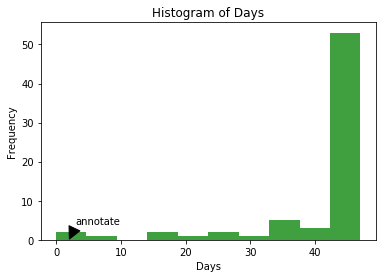

In [71]:
# Histogram of the days
y = merged_speed["diff"].dt.days
n, bins, patches = plt.hist(y, 10, facecolor='g', alpha=0.75)

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram of Days')
plt.annotate('annotate', xy=(2, 0), xytext=(3, 4),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

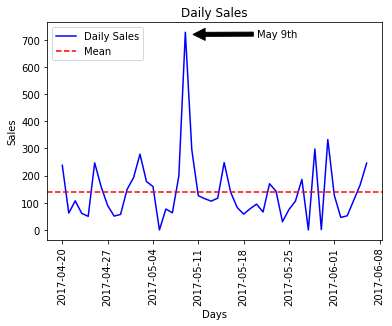

In [115]:
# Daily Sales Graphic
sales = evolutions[evolutions.type == "stock_decrease"][["timestamp", "value"]]
sales.value = sales.value.astype(int)
sales_sum = sales.groupby("timestamp",as_index=False)["value"].sum()
plt.plot(sales_sum.timestamp,sales_sum.value, color="b")
plt.xticks(rotation='vertical')
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Daily Sales")

plt.annotate('May 9th', xy=("2017-05-10", 720), xytext=("2017-05-20", 710),
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.axhline(y=sales_sum.value.mean(), color='r', linestyle='--')
plt.legend(["Daily Sales", "Mean"], loc = "upper left")
plt.show()


In [116]:
sales_sum.value.sum()


6762